### TO DO:
(Problem statement)
(Describe the real-world phenomenon you are studying. Explain why the topic is important,
relevant, or interesting.)
(Uygar)

### TO DO:
(Data description)
Provide a brief description of your dataset, including the data source. 
(Uygar)

### Importing necessary libraries:

In [5]:
import pandas as pd 
import os 
import pymc
import seaborn as sns
import matplotlib.pyplot as plt


# Data preprocessing

### Load the data and put them into data dictionary 

In [6]:
# Data path
data_path = os.path.join(os.getcwd(), '..', 'Data')

# Load the data
life_expectancy = pd.read_csv(os.path.join(data_path, 'estat_demo_mlexpec_en.csv'))
material_deprivation_rate = pd.read_csv(os.path.join(data_path, 'estat_ilc_mdsd04_filtered_en.csv'))
median_and_mean_group_income = pd.read_csv(os.path.join(data_path, 'estat_ilc_di15_filtered_en.csv'))
low_work_intensity_households = pd.read_csv(os.path.join(data_path, 'estat_ilc_lvhl16n_filtered_en.csv'))
real_gdp = pd.read_csv(os.path.join(data_path, 'estat_tipsna40_en.csv'))
population_data = pd.read_csv(os.path.join(data_path, 'estat_demo_pjanbroad_filtered_en.csv'))


# Dataframes dictionary 
dataframes_dict = {
    'life_expectancy': life_expectancy,
    'material_deprivation_rate': material_deprivation_rate,
    'median_and_mean_group_income': median_and_mean_group_income,
    'low_work_intensity_households': low_work_intensity_households,
    'real_gdp': real_gdp,
    'population_data': population_data
}


### Include only EU data and set data collection window to 2004 - 2023
GDP data is not older than 2003, therefore we use a data collection window of 2004 - 2023. For some datasets we don't have data from 2024.

In [7]:
# Include only EU data and set data collection window
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czechia', 'Germany',
       'Denmark','Estonia',
       'Greece', 'Spain', 'Finland', 'France', 'Croatia', 'Hungary', 'Ireland', 'Italy',
       'Lithuania', 'Luxembourg', 'Latvia', 'Malta', 'Netherlands',
       'Poland', 'Portugal', 'Romania', 'Sweden', 'Slovenia', 'Slovakia']

for key, df in dataframes_dict.items():
    dataframes_dict[key] = df[df['Geopolitical entity (reporting)'].isin(eu_countries)].reset_index(drop=True)
for key, df in dataframes_dict.items():
    dataframes_dict[key] = df.loc[(df['TIME_PERIOD'] >= 2004) & (df['TIME_PERIOD'] < 2024)].reset_index(drop=True)


### Filter data for "Less than one year" age group
This data represents the average life expectancy.

In [8]:
# Filter life expectancies for newborns
dataframes_dict['life_expectancy'] = dataframes_dict['life_expectancy'].loc[dataframes_dict['life_expectancy']['age'] == 'Y_LT1'].reset_index(drop=True)

# Filter PPS currency
Median and mean data are available in three formats Euro, regional currency and PPS (Purchasing Power Standrad), we decide to use PPS because it adjusts for price level differences across regions, providing a more accurate basis for cross-country comparisons.

In [9]:
# Filter PPS (Purchasing Power Standard) currency 
dataframes_dict['median_and_mean_group_income'] = dataframes_dict['median_and_mean_group_income'].loc[dataframes_dict['median_and_mean_group_income']['unit'] == 'PPS'].reset_index(drop=True)


### Generalize mean and median data 
Since mean and median values in our dataset are segmented by age groups, we gather corresponding population data and compute weighted averages. This allows us to estimate overall population-level statistics for our analysis. We also remove unnecessary columns. 

In [10]:
# Generalize mean and median data
# Filter age groups present in the data
age_groups = ['From 18 to 64 years', '65 years or over']
dataframes_dict['median_and_mean_group_income'] = dataframes_dict['median_and_mean_group_income'][dataframes_dict['median_and_mean_group_income']['Age class'].isin(age_groups)].reset_index(drop=True)

# Remove unnecessary columns
for key, df in dataframes_dict.items():
    dataframes_dict[key] = df.drop(columns=['STRUCTURE', 'STRUCTURE_NAME', 'STRUCTURE_ID', 'Confidentiality status (flag)', 'CONF_STATUS', 'Observation status (Flag) V2 structure', 'unit', 'Observation value', 'Time', 'geo', 'age', 'Sex',
                                            'Country of citizenship', 'citizen', 'Unit of measure', 'Income and living conditions indicator', 'freq', 'Time frequency', 'OBS_FLAG', 'National accounts indicator (ESA 2010)', 'na_item', 'c_birth', 'Country/region of birth'], errors='ignore')
    
    # Because the income date is available only by population, we need to merge it with population data to be able to combine the date for the whole population
dataframes_dict['population_data'].rename(columns={'OBS_VALUE': 'population'}, inplace=True)
dataframes_dict['population_data'].replace({'Age class': {'From 15 to 64 years': 'From 18 to 64 years'}}, inplace=True)
dataframes_dict['population_data'] = dataframes_dict['population_data'].loc[dataframes_dict['population_data']['Age class'] != 'Less than 15 years'].reset_index(drop=True)

dataframes_dict['median_and_mean_group_income'] = pd.merge(dataframes_dict['median_and_mean_group_income'],
                  dataframes_dict['population_data'],
                  on=['sex','Geopolitical entity (reporting)', 'TIME_PERIOD', 'Age class'],
                  how='left') 

# We group the data to calculate the weighted average of OBS_VALUE by population for each group defined
group_cols = ['sex', 'Geopolitical entity (reporting)', 'TIME_PERIOD', 'indic_il']

def weighted_average(group_df):
    weighted_sum = (group_df['OBS_VALUE'] * group_df['population']).sum()
    total_population = group_df['population'].sum()
    
    if total_population > 0:
        weighted_avg = weighted_sum / total_population
    else:
        weighted_avg = 0 
    
    return pd.Series({
        'OBS_VALUE': weighted_avg
    })

# Transform median and mean into seperate columns
dataframes_dict['median_and_mean_group_income'] = dataframes_dict['median_and_mean_group_income'].groupby(group_cols).apply(weighted_average).reset_index()
dataframes_dict['life_expectancy'] = dataframes_dict['life_expectancy'].drop(columns='Age class')
dataframes_dict['material_deprivation_rate'] = dataframes_dict['material_deprivation_rate'].drop(columns='Age class')
dataframes_dict['low_work_intensity_households'] = dataframes_dict['low_work_intensity_households'].drop(columns='Age class')

dataframes_dict['median_and_mean_group_income']['indic_il']
dataframes_dict['median_and_mean_group_income'] = dataframes_dict['median_and_mean_group_income'].pivot(index=[col for col in dataframes_dict['median_and_mean_group_income'].columns if col not in ['indic_il', 'OBS_VALUE']], columns='indic_il', values='OBS_VALUE').reset_index()


/var/folders/y4/lhggv2xd4_g7wl5ry_nch6q40000gn/T/ipykernel_36350/313758494.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataframes_dict['median_and_mean_group_income'] = dataframes_dict['median_and_mean_group_income'].groupby(group_cols).apply(weighted_average).reset_index()


# Rename columns

In [11]:
# Rename columns 
dataframes_dict['real_gdp'] = dataframes_dict['real_gdp'].rename(columns={'OBS_VALUE': 'real_gdp'})
dataframes_dict['low_work_intensity_households'] = dataframes_dict['low_work_intensity_households'].rename(columns={'OBS_VALUE': 'people_in_low_work_intensity_household_perc'})
dataframes_dict['material_deprivation_rate'] = dataframes_dict['material_deprivation_rate'].rename(columns={'OBS_VALUE': 'material_deprivation_rate_perc'})

### Create columns for GDP, mean and median 5 and 10 years later
We limit the TIME_PERIOD column to values from 2014 to 2023. However, we retain earlier data to compute additional columns for GDP, mean, and median income from 5 and 10 years prior. Data on material and social deprivation rates, as well as the share of people living in low work intensity households, is only available from 2014 onward and is used as-is.

In [12]:
# Limit life expectancy to 2014 
dataframes_dict['life_expectancy'] = dataframes_dict['life_expectancy'].loc[dataframes_dict['life_expectancy']['TIME_PERIOD'] >= 2014].reset_index(drop=True)

# Merge gdp with median and mean
real_gdp_med_mean = pd.merge(dataframes_dict['real_gdp'], dataframes_dict['median_and_mean_group_income'], on=['Geopolitical entity (reporting)', 'TIME_PERIOD'])

# Prepare GDP data for merging by creating shifted year columns
real_gdp_med_mean['TIME_PERIOD_plus_5'] = real_gdp_med_mean['TIME_PERIOD'] + 5
real_gdp_med_mean['TIME_PERIOD_plus_10'] = real_gdp_med_mean['TIME_PERIOD'] + 10

# Merge life expectancy with current year GDP
df_merged = pd.merge(dataframes_dict['life_expectancy'], real_gdp_med_mean[['Geopolitical entity (reporting)', 'TIME_PERIOD', 'real_gdp', 'MED_E', 'MEI_E', 'sex']], how='left', left_on=['Geopolitical entity (reporting)', 'TIME_PERIOD', 'sex'], right_on=['Geopolitical entity (reporting)', 'TIME_PERIOD', 'sex'])
df_merged.rename(columns={'real_gdp': 'real_gdp_current', 'MED_E': 'MED_E_current', 'MEI_E': 'MEI_E_current'}, inplace=True)

# Merge life expectancy with GDP from 5 years before
df_merged = pd.merge(df_merged, real_gdp_med_mean[['Geopolitical entity (reporting)', 'TIME_PERIOD_plus_5', 'real_gdp', 'MED_E', 'MEI_E', 'sex']], how='left', left_on=['Geopolitical entity (reporting)', 'TIME_PERIOD', 'sex'], right_on=['Geopolitical entity (reporting)', 'TIME_PERIOD_plus_5', 'sex'])
df_merged.rename(columns={'real_gdp': 'real_gdp_minus_5', 'MED_E': 'MED_E_minus_5', 'MEI_E': 'MEI_E_minus_5'}, inplace=True)

# Merge life expectancy with GDP from 10 years before
df_merged = pd.merge(df_merged, real_gdp_med_mean[['Geopolitical entity (reporting)', 'TIME_PERIOD_plus_10', 'real_gdp', 'MED_E', 'MEI_E', 'sex']], how='left', left_on=['Geopolitical entity (reporting)', 'TIME_PERIOD', 'sex'], right_on=['Geopolitical entity (reporting)', 'TIME_PERIOD_plus_10', 'sex'])
df_merged.rename(columns={'real_gdp': 'real_gdp_minus_10', 'MED_E': 'MED_E_minus_10', 'MEI_E': 'MEI_E_minus_10'}, inplace=True)

# Cleanup unnecessary columns
df_merged.drop(columns=['TIME_PERIOD_plus_5', 'TIME_PERIOD_plus_10'], inplace=True)



### Merge material and social deprivation rate, and percentage of people living in low workload households

In [16]:
df_full = pd.merge(df_merged, dataframes_dict['low_work_intensity_households'], on=['TIME_PERIOD', 'sex', 'Geopolitical entity (reporting)'])
df_full = pd.merge(df_full, dataframes_dict['material_deprivation_rate'], on=['sex', 'TIME_PERIOD', 'Geopolitical entity (reporting)'])
df_full.head()

,sex,Geopolitical entity (reporting),TIME_PERIOD,OBS_VALUE,real_gdp_current,MED_E_current,MEI_E_current,real_gdp_minus_5,MED_E_minus_5,MEI_E_minus_5,real_gdp_minus_10,MED_E_minus_10,MEI_E_minus_10,people_in_low_work_intensity_household_perc,material_deprivation_rate_perc
0,F,Austria,2015,83.7,39640,23263.169051,25342.505855,38800.0,20206.403705,22544.439063,36950.0,17601.980989,19614.340744,4.4,5.9
1,F,Austria,2016,84.1,39970,24605.250521,26527.179513,39800.0,21228.830471,23461.591105,37970.0,17802.543685,19607.809630,5.3,4.9
2,F,Austria,2017,84.0,40620,24844.221020,27311.593112,39870.0,21636.216198,23801.369122,39270.0,18416.722715,20309.654523,4.9,5.0
3,F,Austria,2018,84.1,41430,24443.071028,26600.126648,39540.0,21898.770604,24150.041558,39710.0,19541.957659,21731.722816,4.7,4.2
4,F,Austria,2019,84.2,41970,25082.305739,27650.039982,39520.0,23041.372948,25606.672200,38200.0,20036.049266,22141.737160,4.7,4.5


### Add mean and median difference, and relative difference

In [ ]:
df_full['mean-median'] = df_full['MEI_E_current'] - df_full['MED_E_current']
df_full['qoutient'] = (df_full['MEI_E_current'] - df_full['MED_E_current']) / df_full['MED_E_current']


### Split data by sex

In [ ]:
women = df_full.loc[df_full['sex'] == 'F'].reset_index(drop=True)
men = df_full.loc[df_full['sex'] == 'M'].reset_index(drop=True)
total = df_full.loc[df_full['sex'] == 'T'].reset_index(drop=True)

### Compute correlation matrices

In [14]:
corr_cols = ['OBS_VALUE', 'real_gdp_current', 'MED_E_current', 'MEI_E_current', 'real_gdp_minus_5', 'MED_E_minus_5', 'MEI_E_minus_5', 'real_gdp_minus_10', 'MED_E_minus_10', 'MEI_E_minus_10','people_in_low_work_intensity_household_perc',
            'material_deprivation_rate_perc', 'mean-median', 'qoutient']

corr_matrix_women = women[corr_cols].corr()
corr_matrix_men = men[corr_cols].corr()
corr_matrix_total = total[corr_cols].corr()

print(corr_matrix_women)
print(corr_matrix_men)
print(corr_matrix_total)


                                             OBS_VALUE  real_gdp_current  \
OBS_VALUE                                     1.000000          0.537073   
real_gdp_current                              0.537073          1.000000   
MED_E_current                                 0.668062          0.868774   
MEI_E_current                                 0.674248          0.866163   
real_gdp_minus_5                              0.553580          0.982611   
MED_E_minus_5                                 0.694355          0.860184   
MEI_E_minus_5                                 0.709198          0.856491   
real_gdp_minus_10                             0.551053          0.956123   
MED_E_minus_10                                0.703464          0.847984   
MEI_E_minus_10                                0.720179          0.838862   
people_in_low_work_intensity_household_perc   0.311313          0.253957   
material_deprivation_rate_perc               -0.567590         -0.529221   
mean-median 

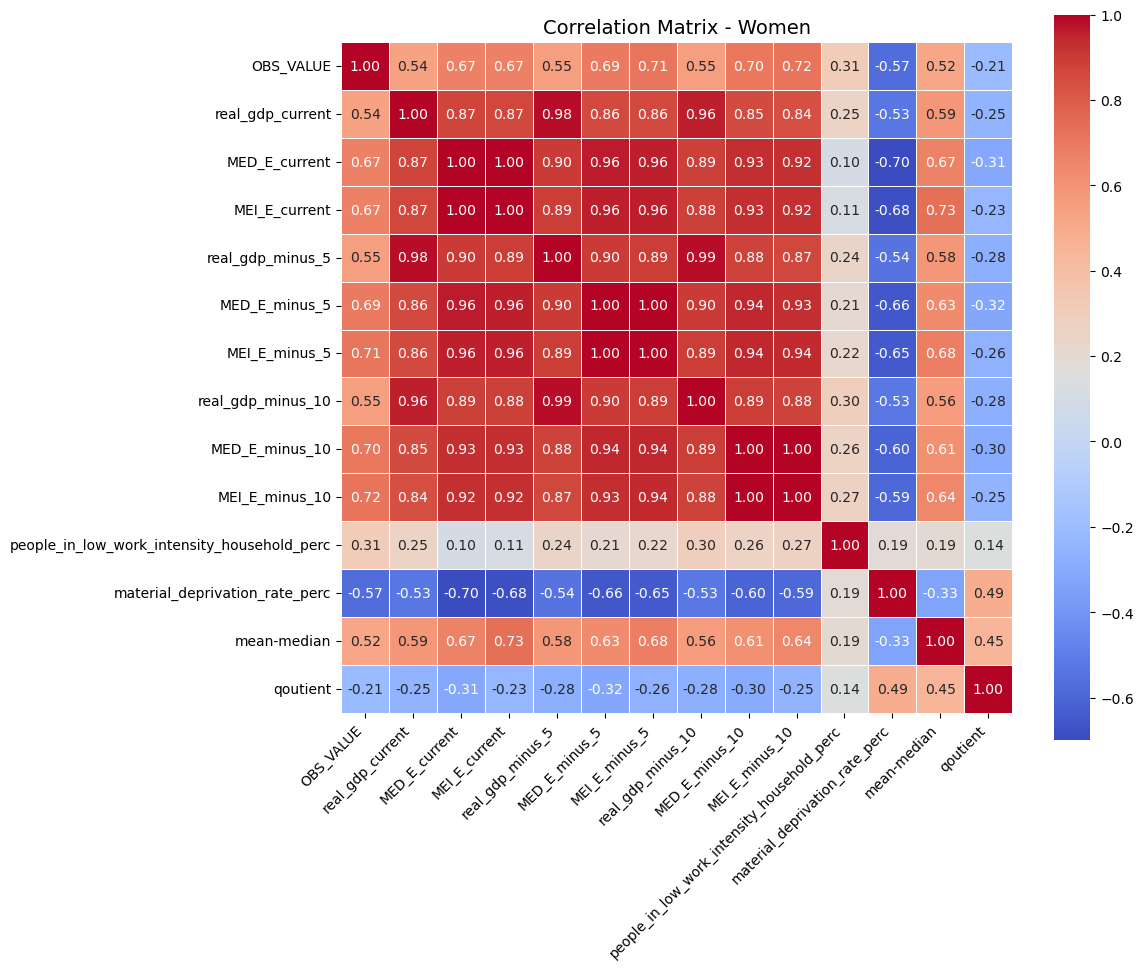

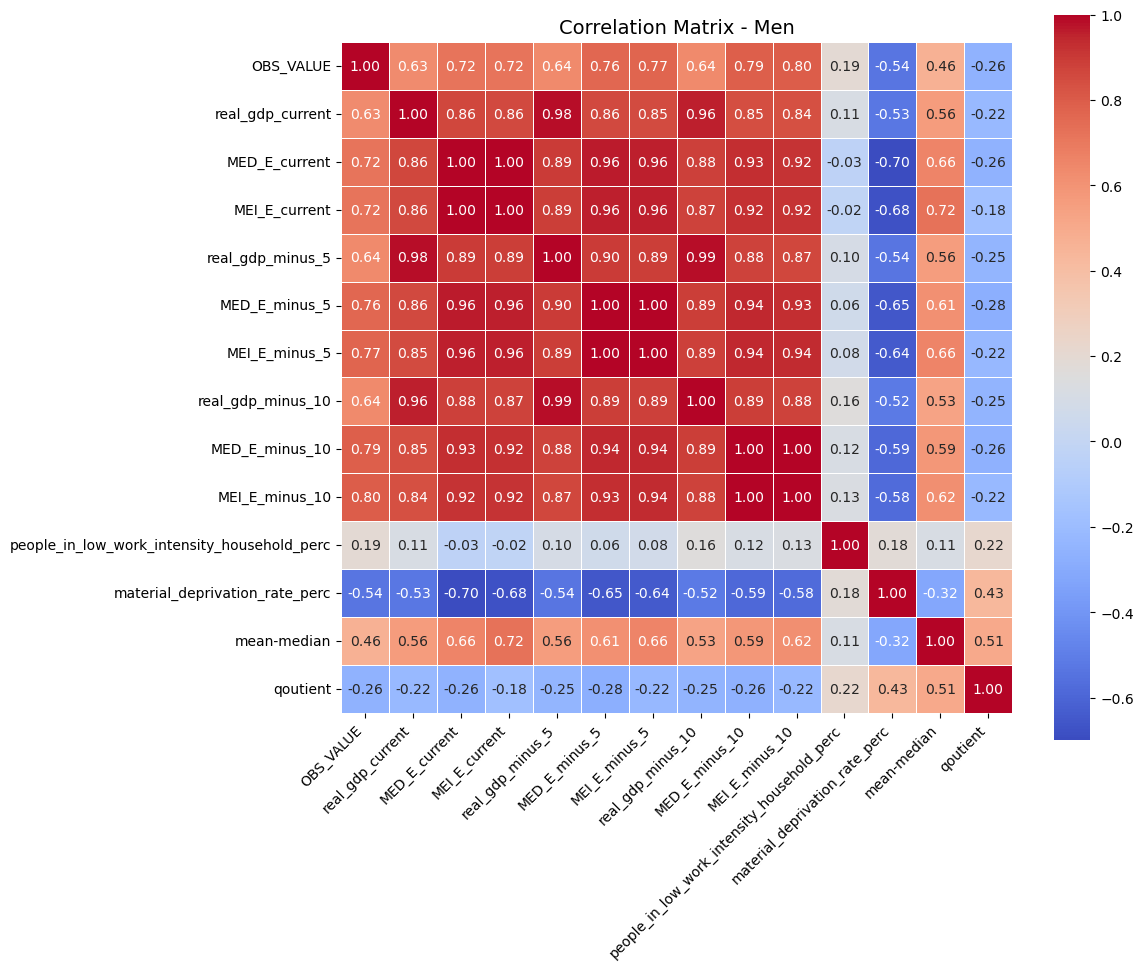

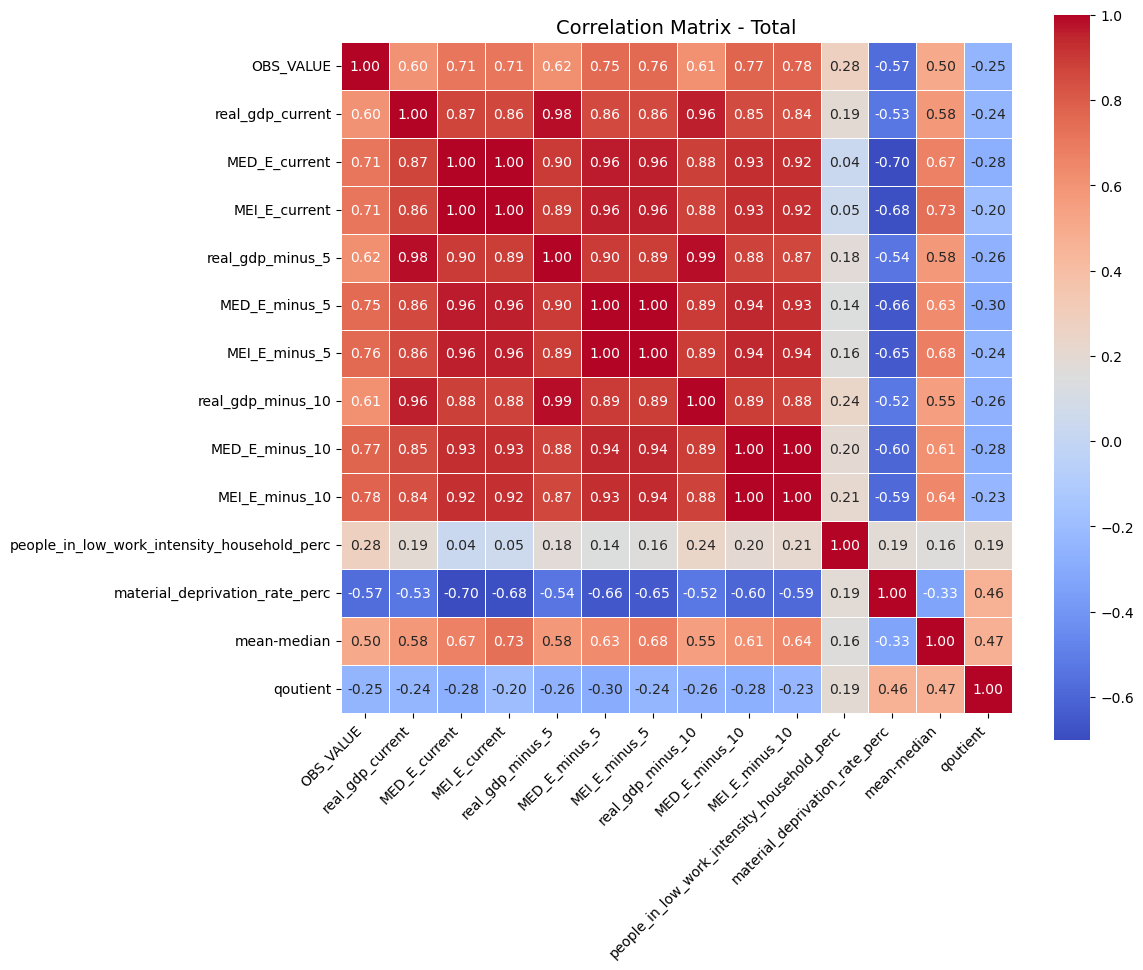

In [15]:



# Assuming 'df_full' already has the necessary columns created:
df_full['mean-median'] = df_full['MEI_E_current'] - df_full['MED_E_current']
df_full['qoutient'] = (df_full['MEI_E_current'] - df_full['MED_E_current']) / df_full['MED_E_current']

# Define correlation columns
corr_cols = [
    'OBS_VALUE', 'real_gdp_current', 'MED_E_current', 'MEI_E_current',
    'real_gdp_minus_5', 'MED_E_minus_5', 'MEI_E_minus_5',
    'real_gdp_minus_10', 'MED_E_minus_10', 'MEI_E_minus_10',
    'people_in_low_work_intensity_household_perc',
    'material_deprivation_rate_perc', 'mean-median', 'qoutient'
]

# Split by sex
women = df_full[df_full['sex'] == 'F'].reset_index(drop=True)
men = df_full[df_full['sex'] == 'M'].reset_index(drop=True)
total = df_full[df_full['sex'] == 'T'].reset_index(drop=True)

# Compute correlation matrices
corr_matrix_women = women[corr_cols].corr()
corr_matrix_men = men[corr_cols].corr()
corr_matrix_total = total[corr_cols].corr()

# Plotting function
def plot_corr_matrix(corr_matrix, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix, 
        annot=True, 
        fmt=".2f", 
        cmap="coolwarm", 
        cbar=True, 
        square=True, 
        linewidths=0.5
    )
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot each
plot_corr_matrix(corr_matrix_women, "Correlation Matrix - Women")
plot_corr_matrix(corr_matrix_men, "Correlation Matrix - Men")
plot_corr_matrix(corr_matrix_total, "Correlation Matrix - Total")
